# Base model: Linear Regression
From the clean database that we analyzed in the ETL stage, we propose a first linear regression model


In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
import numpy as np
import statsmodels.api as smf

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import numpy as np




df = pd.read_parquet("df_completo.parquet")

In [2]:
df_lm_1 = df.drop(columns = "room_sin_outlier", axis =1 )
df_lm_1.dropna(subset = ["area_sin_outlier", "price_sin_outlier"], inplace = True)


In [3]:
df_lm_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18583 entries, 2 to 121217
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price_sin_outlier  18583 non-null  float64
 1   area_sin_outlier   18583 non-null  float64
 2   place_name         18583 non-null  object 
 3   property_type      18583 non-null  object 
 4   subte_m500         18583 non-null  int64  
 5   gastro_m200        18583 non-null  int64  
 6   nuevo              18583 non-null  int64  
 7   alfrente           18583 non-null  int64  
 8   terraza            18583 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 1.4+ MB


In [4]:
df_lm_1

,price_sin_outlier,area_sin_outlier,place_name,property_type,subte_m500,gastro_m200,nuevo,alfrente,terraza
2,72000.0,55.0,Mataderos,apartment,0,0,0,0,0
7,138000.0,45.0,Belgrano,apartment,0,0,1,0,0
8,195000.0,65.0,Belgrano,apartment,0,0,1,0,0
16,239000.0,140.0,Mataderos,PH,0,0,0,1,0
19,350000.0,104.0,Palermo,apartment,0,3,0,1,1
...,...,...,...,...,...,...,...,...,...
121153,165000.0,91.0,Barrio Norte,apartment,1,15,0,0,1
121158,165000.0,44.0,Recoleta,apartment,1,4,0,1,0
121160,410000.0,157.0,Belgrano,apartment,0,1,0,1,0
121209,410000.0,157.0,Belgrano,apartment,0,1,0,1,0


In [5]:
df_lm_2 = pd.get_dummies(df_lm_1, columns = ["property_type", "place_name"])

In [6]:
df_lm_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18583 entries, 2 to 121217
Data columns (total 73 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price_sin_outlier                18583 non-null  float64
 1   area_sin_outlier                 18583 non-null  float64
 2   subte_m500                       18583 non-null  int64  
 3   gastro_m200                      18583 non-null  int64  
 4   nuevo                            18583 non-null  int64  
 5   alfrente                         18583 non-null  int64  
 6   terraza                          18583 non-null  int64  
 7   property_type_PH                 18583 non-null  uint8  
 8   property_type_apartment          18583 non-null  uint8  
 9   property_type_house              18583 non-null  uint8  
 10  property_type_store              18583 non-null  uint8  
 11  place_name_Abasto                18583 non-null  uint8  
 12  place_name_Agrono

In [7]:
#Observamos que los p-value de nuevo, terraza y al frente son altos y por esto lo sacamos del modelo. 

target_var = "price_sin_outlier"
exclude_var = ["property_type_apartment","place_name_Palermo","nuevo","terraza","alfrente"]
feature_cols = set(df_lm_2.columns.to_list()) - set([target_var]) - set(exclude_var)
feature_cols = list(feature_cols)

In [8]:


y = df_lm_2[target_var]
X = df_lm_2[feature_cols]


#Scaler.
scal = StandardScaler()
df2ml_palce_name_k_scaled = df_lm_2.copy()
df2ml_palce_name_k_scaled[feature_cols] = scal.fit_transform(df2ml_palce_name_k_scaled[feature_cols])

#split
X_train, X_test, y_train, y_test = train_test_split(df2ml_palce_name_k_scaled[feature_cols],
                                                    df2ml_palce_name_k_scaled[target_var],
                                                    shuffle=True, 
                                                    random_state=10)

In [9]:


linreg = LinearRegression()
linreg.fit(X_train,y_train)
test_pred = linreg.predict(X_test)

print ('MAE:', metrics.mean_absolute_error(y_test, test_pred))
print ('MSE:', metrics.mean_squared_error(y_test, test_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, test_pred)))
print ('R2:', metrics.r2_score(y_test, test_pred))


MAE: 51336.101848954866
MSE: 6806775623.065846
RMSE: 82503.18553283774
R2: 0.6242277958312146


<AxesSubplot:xlabel='True Values', ylabel='Predicted Values'>

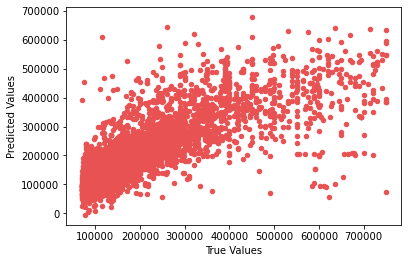

In [10]:

prueba_df = pd.DataFrame({'True Values': y_test, 'Predicted Values': test_pred})
prueba_df.plot.scatter(x='True Values', y='Predicted Values', color = "#e85252ff")

<AxesSubplot:ylabel='Frequency'>

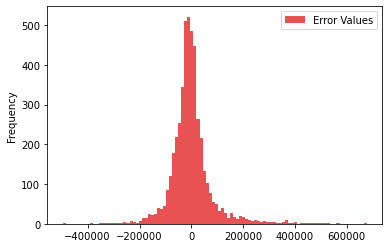

In [11]:
pd.DataFrame({'Error Values': (y_test - test_pred)}).plot(kind = "hist", bins  = 100, color = "#e85252ff")


In [12]:

coeff_df = pd.DataFrame(linreg.coef_, X_train.columns, columns=['Coefficient'])
coeff_df.reset_index(inplace = True)

df2 = {'index': "Intercept", "Coefficient":linreg.intercept_}

df_coeffs= coeff_df.append(df2, ignore_index = True)

df_coeffs


,index,Coefficient
0,place_name_Parque Chas,-3358.834914
1,place_name_Floresta,-13965.245537
2,place_name_Palermo Soho,-3244.846246
3,place_name_Parque Chacabuco,-7111.132878
4,place_name_Puerto Madero,21036.665334
...,...,...
63,place_name_Parque Avellaneda,-6706.290370
64,place_name_Villa Urquiza,-13497.638903
65,place_name_Boedo,5212.332857
66,place_name_Flores,-19998.070726


<AxesSubplot:>

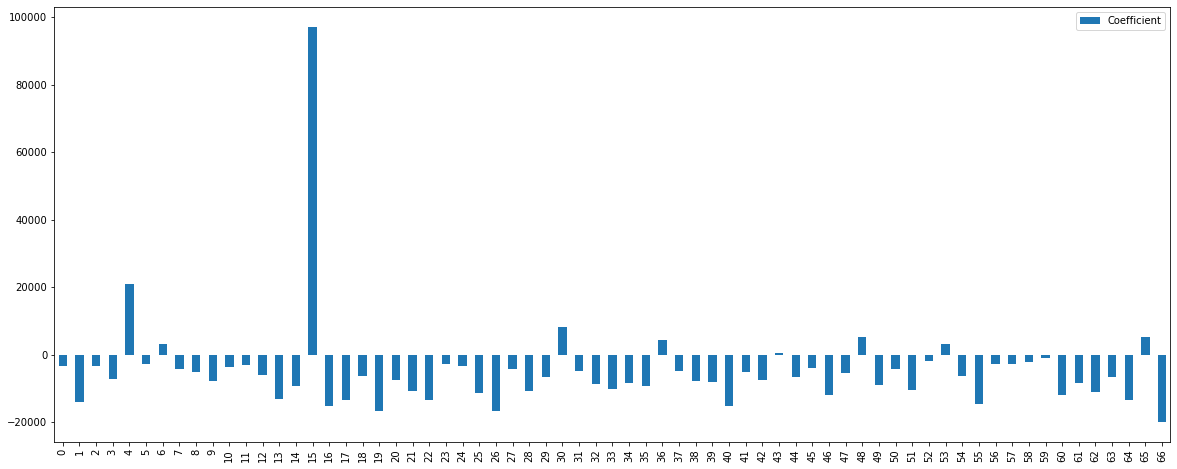

In [13]:

coeff_df.plot(kind="bar", figsize = (20,8))

In [14]:

X = smf.add_constant(X_train)
mod= smf.OLS(y_train, X)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:      price_sin_outlier   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     383.8
Date:                Fri, 17 Sep 2021   Prob (F-statistic):               0.00
Time:                        21:09:23   Log-Likelihood:            -1.7709e+05
No. Observations:               13937   AIC:                         3.543e+05
Df Residuals:                   13869   BIC:                         3.548e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

C:\Users\Claudio\anaconda3\envs\dhdsblend2021_geopandas\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Reducción de dimensionalidad con K-means

#### Se plantea un algoritmo no supervisado para tratar de agrupar barrios similares y de esta forma bajar la dimensionalidad y tratar de mejorar el scoring del modelo. Para esto se define la columna price_m2 para hacer este agrupamiento


In [15]:
df["price_m2"] = df["price_sin_outlier"] / df["area_sin_outlier"]

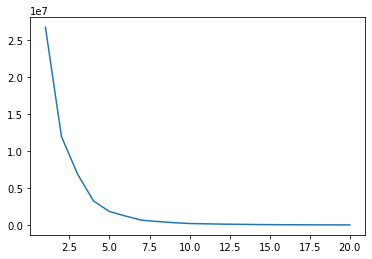

In [16]:


#----------- Kmeans ------------
df_coun_price_place=df.groupby("place_name").agg(conteo = ('area_sin_outlier',lambda x: len(x)/df.shape[0]),precio_medio = ('price_m2','median'))
df_coun_price_place.head()

inertias = []
for x in range(1,21):
    kmeans = KMeans(n_clusters=x,random_state=1457).fit(df_coun_price_place)
    inertias.append(kmeans.inertia_)
    
plt.plot(list(range(1,21)),inertias)

kmeans_fit = KMeans(n_clusters = 4,random_state=1457).fit(df_coun_price_place)
df_coun_price_place["group"] = kmeans_fit.labels_
df_coun_price_place.reset_index(inplace=True)

In [17]:
df_groups = df.merge(df_coun_price_place[["place_name","group"]],on=["place_name"],how = "left")
df_groups = pd.get_dummies(df_groups, columns = ["property_type", "place_name", "group"])

In [18]:
df_groups_sin_room = df_groups.drop(columns = "room_sin_outlier", axis =1 )

In [19]:

df_groups_sin_room.dropna(subset = ["area_sin_outlier", "price_sin_outlier"], inplace = True)


In [20]:
target_var = "price_sin_outlier"
exclude_var = ["price_m2", "place_name","group_0","property_type_apartment","group_ordinal"]
feature_cols = set(df_lm_2.columns.to_list()) - set([target_var]) - set(exclude_var)
feature_cols = list(feature_cols)


In [21]:
feature_cols_area_groups_ordinal_property = ["area_sin_outlier", "group_1","group_2","group_3","property_type_house","property_type_PH","property_type_store","nuevo"]

In [22]:

y = df_groups_sin_room[target_var]
X = df_groups_sin_room[feature_cols]


In [23]:
#Acá no se usa el train-test-split porque eso lo hace ya el crossval no?


cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = LinearRegression()

scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)

In [24]:
scores

array([0.63856604, 0.66064839, 0.65355233, 0.61782283, 0.61329782,
       0.61469785, 0.65902568, 0.66817136, 0.63093661, 0.65451823])

In [25]:
scores.mean()

0.64112371404781

In [26]:
#No se bien que me falta acá o cuándo nos dimos cuenta de que este modelo no funcionaba por el Data Leakeage

# Se plantea un modelo penalizado Ridge para mejorar el modelo baseline que tenemos

### El modelo K-means si bien mejora un poco el score está conceptualmente mal ya que hay un data leakeage de price_m2 por tener la variable target metida dentro

In [27]:
#Acá tomamos el mismo dataframe que en baseline. Sin grupos de barrios, barrios sin outliers, rooms sin ouliers y price sin outliers

y = df_lm_2[target_var]
X = df_lm_2[feature_cols]

In [28]:

ridge_alphas = np.linspace(0, 10000, 100)
ridge = linear_model.Ridge()
grid = dict()
grid['alpha'] = ridge_alphas
gscv = GridSearchCV( \
    ridge, grid, scoring='r2', \
    cv=cv, n_jobs=-1)

results_ridge = gscv.fit(X, y)

#Acá no es necesario hacer el split train test tampoco?



In [29]:
results_ridge_df = pd.DataFrame(results_ridge.cv_results_)
results_ridge_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.344378,0.270641,0.010902,0.006475,0.0,{'alpha': 0.0},0.638566,0.660745,0.653552,0.618227,0.613347,0.614800,0.658987,0.668171,0.630937,0.653035,0.641037,0.019573,1
1,0.095518,0.028768,0.013652,0.007858,101.010101,{'alpha': 101.01010101010101},0.621604,0.645090,0.637996,0.601571,0.594502,0.599979,0.647535,0.656075,0.613940,0.653203,0.627150,0.022437,2
2,0.080073,0.017514,0.006098,0.002118,202.020202,{'alpha': 202.02020202020202},0.605750,0.629434,0.622945,0.586541,0.579295,0.586676,0.633198,0.643075,0.599045,0.643231,0.612919,0.023177,3
3,0.062779,0.016757,0.009497,0.007457,303.030303,{'alpha': 303.030303030303},0.593237,0.616929,0.611125,0.574640,0.567661,0.575967,0.621497,0.632280,0.587505,0.634110,0.601495,0.023503,4
4,0.058382,0.012959,0.007598,0.007239,404.040404,{'alpha': 404.04040404040404},0.583120,0.606780,0.601554,0.564978,0.558323,0.567113,0.611839,0.623273,0.578203,0.626220,0.592140,0.023675,5


In [30]:
#Como alfa es cero el modelo de regresión lineal que calculamos como base queda sin modificarse. 
results_ridge.best_params_

{'alpha': 0.0}

In [31]:
results_ridge.best_score_

0.6410367070636593

# Como el modelo predice con poca capacidad pretendemos mejorar el mismo agregando un campo más que sea el ingreso medio por comuna.


### para esto importamos un dataset nuevo que son las comunas de CABA y pretendemos cruzar los datos entre estas bases y mejorar la performance del mismo

In [32]:
import geopandas as gpd

filename = "CABA_comunas.geojson"
file = open(filename, encoding ="utf8")
geo_comuna = gpd.read_file(file)
geo_comuna = geo_comuna.set_crs("epsg:5349", allow_override = True)
geo_comuna.head()

,WKT,ID,OBJETO,COMUNAS,BARRIOS,PERIMETRO,AREA,geometry
0,MULTIPOLYGON (((-58.3800038855693 -34.57002352...,1,LIMITE COMUNAL,2.00000000000,RECOLETA,21452.83864780000,6317264.56099000107,"MULTIPOLYGON (((-58.38000 -34.57002, -58.38002..."
1,MULTIPOLYGON (((-58.4306058283309 -34.60704708...,3,LIMITE COMUNAL,6.00000000000,CABALLITO,10990.96447150000,6851028.91356999893,"MULTIPOLYGON (((-58.43061 -34.60705, -58.43056..."
2,MULTIPOLYGON (((-58.4883373673246 -34.62016035...,6,LIMITE COMUNAL,10.00000000000,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.03745670000,12656556.93779999949,"MULTIPOLYGON (((-58.48834 -34.62016, -58.48820..."
3,MULTIPOLYGON (((-58.498384839883 -34.596367656...,7,LIMITE COMUNAL,11.00000000000,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.69615500000,14120042.42380000092,"MULTIPOLYGON (((-58.49838 -34.59637, -58.49718..."
4,MULTIPOLYGON (((-58.5033113250844 -34.59385615...,8,LIMITE COMUNAL,12.00000000000,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.18937200000,15570926.63759999909,"MULTIPOLYGON (((-58.50331 -34.59386, -58.50347..."


In [33]:
import geopandas as gpd
import pandas as pd
geo_caba = pd.read_parquet("geo_caba_mod.parquet")
geo_caba = gpd.GeoDataFrame(geo_caba, geometry = gpd.points_from_xy(geo_caba.lon, geo_caba.lat))
geo_caba.head()

geo_caba = geo_caba.set_crs("epsg:5349", allow_override = True)

In [34]:
def lock_comuna(propiedad):
    try:
        mask = geo_comuna.contains(propiedad)
        return int(float(geo_comuna.loc[mask, "COMUNAS"].values[0]))
    except:
        pass
        
    

In [35]:
geo_caba["comunas"] = geo_caba["geometry"].apply(lambda x: lock_comuna(x))

In [36]:
geo_caba_modelo = geo_caba.copy()

In [37]:
geo_caba_modelo = geo_caba_modelo.dropna(subset = ["comunas"])

In [38]:
geo_caba_modelo.shape

(21953, 82)

In [39]:
geo_caba["geometry"].head()

0     POINT (-58.50884 -34.66182)
2     POINT (-58.52298 -34.65226)
7     POINT (-58.44336 -34.55987)
8     POINT (-58.44336 -34.55987)
16    POINT (-58.50162 -34.65236)
Name: geometry, dtype: geometry

In [40]:
diccionario = {1:72681,
2:75944,
3:48715,
4:47606,
5:58941,
6:69510,
7:60252,
8:49424,
9:53797,
10:64337,
11:62991,
12:76005,
13:80052,
14:85061,
15:63423}


In [41]:
geo_caba_modelo["ingreso_medio_comuna"] = geo_caba_modelo["comunas"].map(diccionario)

In [42]:
geo_caba_modelo_df= pd.DataFrame(geo_caba_modelo)

In [43]:
geo_caba_modelo_df = pd.get_dummies(geo_caba_modelo_df,columns = ["comunas"], prefix = "comuna")

In [44]:
geo_caba_modelo_df

,property_type,lat,lon,price_parseado,room_parseada,area_completa,description,nuevo,terraza,alfrente,...,comuna_6.0,comuna_7.0,comuna_8.0,comuna_9.0,comuna_10.0,comuna_11.0,comuna_12.0,comuna_13.0,comuna_14.0,comuna_15.0
0,PH,-34.661824,-58.508839,62000.0,NaN,55.0,"2 ambientes tipo casa planta baja por pasillo,...",0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,apartment,-34.652262,-58.522982,72000.0,NaN,55.0,2 ambientes 3er piso lateral living comedor am...,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,apartment,-34.559873,-58.443362,138000.0,1.0,45.0,excelente monoambiente a estrenar amplio super...,1,0,0,...,0,0,0,0,0,0,0,1,0,0
8,apartment,-34.559873,-58.443362,195000.0,NaN,65.0,excelente dos ambientes estrenar amplio super...,1,0,0,...,0,0,0,0,0,0,0,1,0,0
16,PH,-34.652356,-58.501624,239000.0,4.0,140.0,ventas mataderos al frente duplex 4 amb.- plan...,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121153,apartment,-34.599214,-58.402519,165000.0,NaN,91.0,excelente departamento con terraza propia y pa...,0,1,0,...,0,0,0,0,0,0,0,0,0,0
121158,apartment,-34.587425,-58.397372,165000.0,1.0,44.0,excelente ubicación - avenida pueyrredon y las...,0,0,1,...,0,0,0,0,0,0,0,0,0,0
121160,apartment,-34.563685,-58.442683,410000.0,NaN,157.0,edificio en esquina de muy buena categoría de ...,0,0,1,...,0,0,0,0,0,0,0,0,1,0
121209,apartment,-34.563685,-58.442683,410000.0,NaN,157.0,edificio en esquina de muy buena categoría de ...,0,0,1,...,0,0,0,0,0,0,0,0,1,0
